In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as k
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np

### mnist 에서 데이터를 다운받아 학습/테스트 데이터로 분리

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

mnist 데이터는 28*28 픽셀로 구성되어 있다.

각 픽셀은 흑백사진으로 0~255 사이의 그레이스케일 형식으로 구성되어 있다.

0: 흰색, 255: 검은색

In [3]:
print(x_train[0][8])

[  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241
   0   0   0   0   0   0   0   0   0   0]


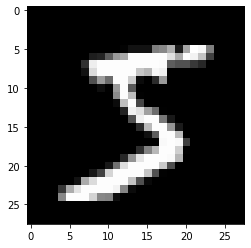

In [8]:
image = x_train[0]
image.shape
print()

plt.imshow(image, 'gray')
plt.show()

In [9]:
# 학습용
x_train.shape

(60000, 28, 28)

In [10]:
# 테스트용
y_test.shape

(10000,)

# 데이터 구조 변경하기
입력레이어에 데이터를 넣기 위해서 데이터의 구조를 변경해 주어야 한다.

In [12]:
import numpy as np

x_train = np.reshape(x_train, (60000, 28, 28, 1))
x_test = np.reshape(x_test, (10000, 28, 28, 1))

In [15]:
print(x_train.shape)
print()
print(x_test.shape)

(60000, 28, 28, 1)

(10000, 28, 28, 1)


In [20]:
# 차원 수 확인 , 4차원으로 차원수를 올려서 역전파함
x_train.ndim

4

# 데이터 정규화
데이터의 정규화는 학습 시간을 단축시키고, 성능 구현을 올려준다.

MNIST의 정규화는 최대값 255를 각각의 값으로 나눠준다. -> 0 ~ 1.0 사이의 값으로 분포

In [21]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [22]:
gray_scale = 255

x_train /= gray_scale
x_test /= gray_scale

In [28]:
x_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

# 실제값을 원핫 인코딩으로 변경

손실 함수에서 크로스엔트로피를 계산하기 위해서 변경해준다.

In [30]:
num_classes = 10

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

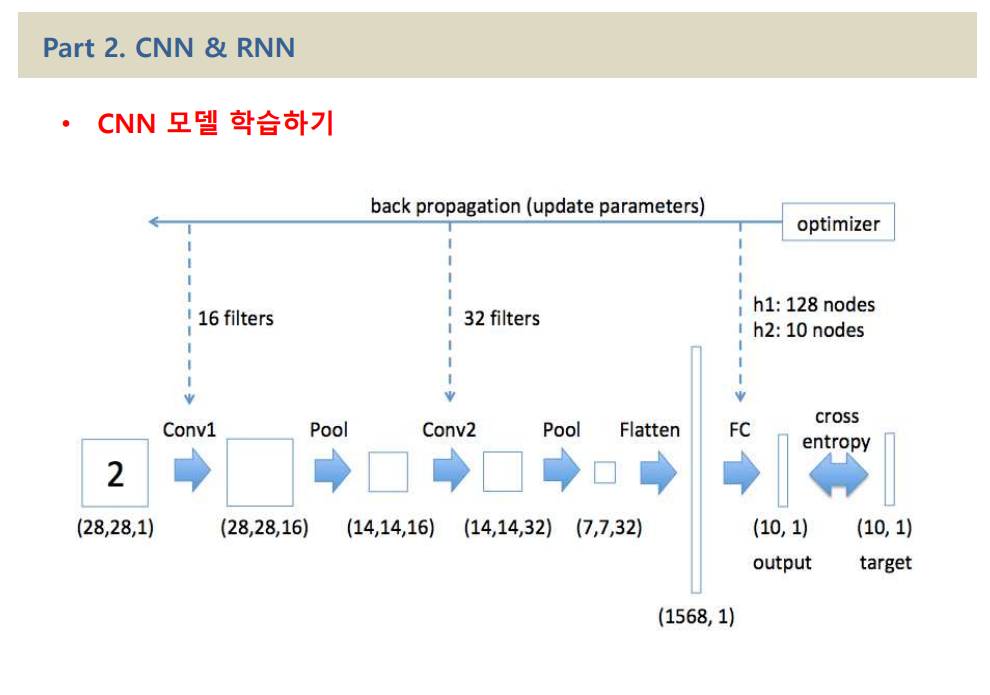

# 모델선택

In [35]:
model = Sequential()

# Conv 레이어에서는 총 16개의 필터를 가지고 있으며, 필터의 크기는 5*5
model.add(Conv2D(16, kernel_size=(5,5),
                activation='relu',
                input_shape=(28,28,1),
                padding='same'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(5,5),
                activation='relu',
                input_shape=(28,28,1),
                padding='same'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# 정보확인

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

# 최적화

In [38]:
model.compile(loss=categorical_crossentropy,
             optimizer=Adam(),
             metrics=['accuracy'])

# 조기종료 설정 (조건에 안맞으면 종료)

In [39]:
# 모델링시 두번이상 모델의 개선사항이 없을경우 (조기종료 실행)
callbacks = [EarlyStopping(monitor='val_accuracy',
                          patience=2,
                          restore_best_weights=False),
            ModelCheckpoint(filepath='best_model.h5',
                           monitor='val_accuracy',
                           save_best_only='True')]

# 학습시키기

In [42]:
model.fit(x_train, y_train,
         batch_size=500,
         epochs=5,
         verbose=1,
         validation_split=0.1,
         callbacks=callbacks)

Epoch 1/5
108/108 [==============================] - 27s 236ms/step - loss: 0.9593 - accuracy: 0.7295 - val_loss: 0.1244 - val_accuracy: 0.9633
Epoch 2/5
108/108 [==============================] - 24s 226ms/step - loss: 0.1337 - accuracy: 0.9596 - val_loss: 0.0867 - val_accuracy: 0.9745
Epoch 3/5
108/108 [==============================] - 24s 227ms/step - loss: 0.0833 - accuracy: 0.9746 - val_loss: 0.0615 - val_accuracy: 0.9828
Epoch 4/5
108/108 [==============================] - 24s 227ms/step - loss: 0.0612 - accuracy: 0.9812 - val_loss: 0.0547 - val_accuracy: 0.9852
Epoch 5/5
108/108 [==============================] - 24s 225ms/step - loss: 0.0455 - accuracy: 0.9866 - val_loss: 0.0533 - val_accuracy: 0.9845


# 테스트 결과 확인

In [43]:
score = model.evaluate(x_test, y_test, verbose=bose=1)

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

313/313 [==============================] - 2s 4ms/step - loss: 0.0439 - accuracy: 0.9862
Test loss:  0.04390836879611015
Test accuracy:  0.9861999750137329
